### Data Analysis - MODS207
## Authors: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

The goal of this notebook is to explore the collected data, visualize it to acquire insights, and run regression models.

### Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read processed data
df_cities_static = pd.read_csv('../data/proc_data/cities_static.csv.zip', index_col=0)
df_cities_temp = pd.read_csv('../data/proc_data/cities_temp.csv.zip', parse_dates=[3], index_col=0)

In [3]:
# merge important data into one dataframe
df_cities_static['gdp_pc'] = df_cities_static['gdp'].div(df_cities_static['population'])
df_cities_static['density'] = df_cities_static['population'].div(df_cities_static['area'])

df_cities_temp['city_code'] = df_cities_temp['city_code'].astype(int)

static_cols = [
    'city_code', 
    'population',
    'gdp_pc',
    'density',
    'urbanization',
    'white_collar',
    'blue_collar',
    'serv_sanitation',
    'serv_water',
    'serv_sewage',
    'serv_garbage',
    'serv_rainwater',
]

df = pd.merge(df_cities_temp, df_cities_static[static_cols], on='city_code', how='left')

In [4]:
# prepare withdrawal data to account for the delayed effect of covid contamination
days_to_confirmation_avg = 21
days_to_confirmation_std = 7

# shift withdrawal dates
shifted_withdrawal = pd.DataFrame()
shifted_withdrawal['withdrawal_lagged'] = df['withdrawal']
shifted_withdrawal['city_code'] = df['city_code']
dates = df['date']
shifted_withdrawal['date'] = dates + pd.Timedelta(days=days_to_confirmation_avg)
df = pd.merge(df, shifted_withdrawal, on=['city_code', 'date'], how='left')

#apply gaussian smoothing
df['withdrawal_lagged_smooth'] = df.groupby('city_code')['withdrawal_lagged'].rolling(
    60,
    min_periods=1,
    win_type='gaussian',
    center=True
).mean(std=days_to_confirmation_std).values

In [5]:
# smooth covid variables
df['confirmed_day_smooth'] = df.groupby('city_code')['confirmed_day'].rolling(window=15).mean().values
df['deaths_day_smooth'] = df.groupby('city_code')['deaths_day'].rolling(window=15).mean().values

In [7]:
# add state dummy variable
df['is_SP'] = df['state'] == 'SP'
df

,city_name,city_code,date,state,withdrawal,cable_tv_accesses,fixed_bandwidth_accesses,fixed_telephony_accesses,2G_mobile_accesses,3G_mobile_accesses,...,serv_sanitation,serv_water,serv_sewage,serv_garbage,serv_rainwater,withdrawal_lagged,withdrawal_lagged_smooth,confirmed_day_smooth,deaths_day_smooth,is_SP
0,ABAÍRA,2900108,2020-04-13,BA,0.571,979,220,735.0,580.0,661.0,...,1.0,1.0,1.0,1.0,1.0,NaN,0.561667,NaN,NaN,False
1,ABAÍRA,2900108,2020-04-14,BA,0.556,979,220,735.0,580.0,661.0,...,1.0,1.0,1.0,1.0,1.0,NaN,0.559100,NaN,NaN,False
2,ABAÍRA,2900108,2020-04-15,BA,0.596,979,220,735.0,580.0,661.0,...,1.0,1.0,1.0,1.0,1.0,NaN,0.550000,NaN,NaN,False
3,ABAÍRA,2900108,2020-04-16,BA,0.588,979,220,735.0,580.0,661.0,...,1.0,1.0,1.0,1.0,1.0,NaN,0.545833,NaN,NaN,False
4,ABAÍRA,2900108,2020-04-17,BA,0.500,979,220,735.0,580.0,661.0,...,1.0,1.0,1.0,1.0,1.0,NaN,0.545308,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164488,VOTUPORANGA,3557105,2021-02-22,SP,0.390,3004,8405,13934.0,6518.0,9833.0,...,1.0,1.0,1.0,1.0,1.0,0.39,NaN,15.600000,0.333333,True
164489,VOTUPORANGA,3557105,2021-02-23,SP,0.390,3004,8405,13934.0,6518.0,9833.0,...,1.0,1.0,1.0,1.0,1.0,0.39,NaN,16.666667,0.333333,True
164490,VOTUPORANGA,3557105,2021-02-24,SP,0.380,3004,8405,13934.0,6518.0,9833.0,...,1.0,1.0,1.0,1.0,1.0,0.37,NaN,22.466667,0.400000,True
164491,VOTUPORANGA,3557105,2021-02-25,SP,0.400,3004,8405,13934.0,6518.0,9833.0,...,1.0,1.0,1.0,1.0,1.0,0.39,NaN,23.266667,0.400000,True


#### Filtering

For the following analyses, we will only consider cities with more than 100.000 population, since they convey the cities that were mostly affected by the Covid-19 pandemic. Additionally, we will only consider data entries that registered more than one case of Covid-19 per day and with a social withdrawal index higher than 30%.

In [9]:
# apply filtering conditions
mask = (df['population'] > 100000) & (df['confirmed_day'] > 0) & (df['withdrawal'] > 0.4)
df = df.loc[mask, :]

# drop NaN values from dataset
df.dropna(inplace=True)

### Geographic plots

We want to see how some important data is distibuted in the map because it might need to apply some filters.

In [ ]:
import requests
import plotly.express as px

In [ ]:
# GeoJSON URL
URL_CITIES_MAP = "https://github.com/tbrugz/geodata-br/raw/master/geojson/geojs-100-mun.json"

# Obtains Cities GeoJSON
r = requests.get(URL_CITIES_MAP)
CITIES_geojson = r.json()

In [ ]:
def last_value(df):
    return df.iloc[-1:]

def plot_city_map(df, col, method, title):

    # Obtains the grouped dataframe
    if method == "mean":
        df_grouped = df.groupby("city_code").mean()
    elif method == "sum":
        df_grouped = df.groupby("city_code").sum()
    elif method == "size":
        df_grouped = df.groupby("city_code").size()
    elif method == "last_value":
        df_grouped = df.groupby("city_code").apply(last_value)

    else:
        raise Exception("Inserted method not supported (must be 'mean' or 'sum')")
    df_grouped = df_grouped.rename_axis("city_code").reset_index()
    
    
    # Plot the map
    fig = px.choropleth_mapbox(
        df_grouped,
        color = col,
        title = title,
        geojson = CITIES_geojson,
        locations = "city_code",
#         labels = { col: f"{col} {method}" },
        featureidkey = "properties.id",
        range_color = ( np.min(df_grouped[col]), np.max(df_grouped[col]) ),
#         center = { "lat": np.mean(df["coordinates.latitude"]), "lon": np.mean(df["coordinates.longitude"]) },
        center = {"lat": -16.977749, "lon": -45.501630},
        zoom = 3.7,            
        opacity = 0.4,
        color_continuous_scale = "Deep",
        mapbox_style = "carto-positron"
    )
    fig.show()

#### Social distance per city

In [ ]:
plot_city_map(df=df, col="withdrawal", method="mean", title="Withdrawal per city")

We can see for instance that the withdrawal in the SP state seems bigger than the BA state. This can be related with a lot of topics as income per capta, infrastructure and social and economic policies.

#### Accumulate Deaths per Capta

In [ ]:
df_ = df[:]
df_['death_pc'] = df['deaths_day'].div(df['population'])
plot_city_map(df=df_, col="death_pc", method="sum", title="Accumulate Deaths per Capita in the cities")

We can also see the number of deaths per capta in SP state much bigger than in the BA state, which is curious because in the SP state we have more social distance. Although, the state of SP has a bigger demographic density which can influence also in the number of deaths.

#### Deaths per Day and Withdrawal

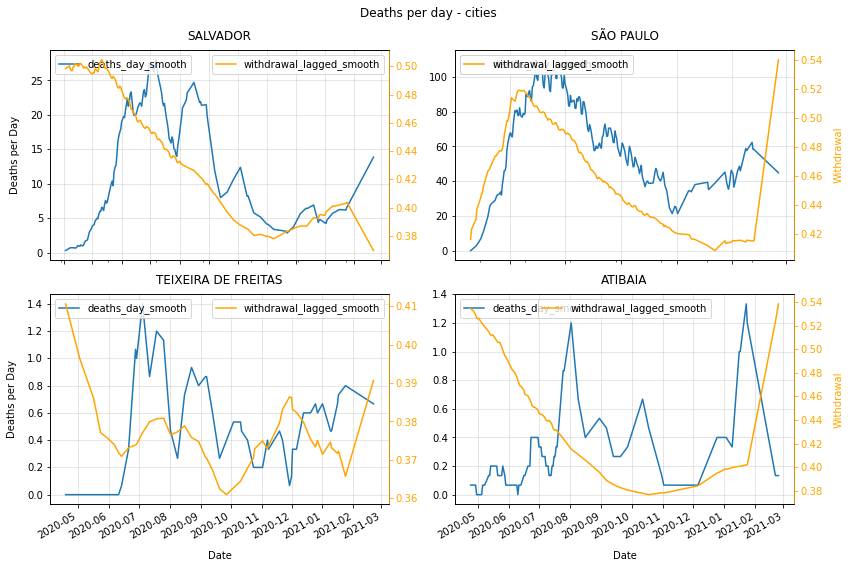

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8))

df[df['city_name']=='SALVADOR'].plot('date', 'deaths_day_smooth', ax=ax1)
ax1.legend(loc='upper left')
ax1_ = ax1.twinx()
df[df['city_name']=='SALVADOR'].plot('date', 'withdrawal_lagged_smooth', c='orange', ax=ax1_)
ax1.set_xlabel('Date', labelpad=10)
ax1.set_ylabel('Deaths per Day', labelpad=10)
ax1.set_title('SALVADOR', pad=10)
# ax1.set(ylim=(0.2, 0.7))
ax1.grid(alpha=0.4)
ax1_.spines['right'].set_color('orange')
ax1_.tick_params(axis='y', color='orange', labelcolor='orange')


df[df['city_name']=='SÃO PAULO'].plot('date', 'deaths_day_smooth', ax=ax2)
ax2.legend(loc='upper left')
ax2_ = ax2.twinx()
df[df['city_name']=='SÃO PAULO'].plot('date', 'withdrawal_lagged_smooth', c='orange', ax=ax2_)
ax2.set_xlabel('Date', labelpad=10)
ax2.set_title('SÃO PAULO', pad=10)
# ax2.set(ylim=(0.2, 0.7))
ax2.grid(alpha=0.4)
ax2_.spines['right'].set_color('orange')
ax2_.tick_params(axis='y', color='orange', labelcolor='orange')
ax2_.set_ylabel('Withdrawal', labelpad=10, color='orange')


df[df['city_name']=='TEIXEIRA DE FREITAS'].plot('date', 'deaths_day_smooth', ax=ax3)
ax3.legend(loc='upper left')
ax3_ = ax3.twinx()
df[df['city_name']=='TEIXEIRA DE FREITAS'].plot('date', 'withdrawal_lagged_smooth', c='orange', ax=ax3_)
ax3.set_xlabel('Date', labelpad=10)
ax3.set_ylabel('Deaths per Day', labelpad=10)
ax3.set_title('TEIXEIRA DE FREITAS', pad=10)
# ax3.set(ylim=(0.2, 0.7))
ax3.grid(alpha=0.4)
ax3_.spines['right'].set_color('orange')
ax3_.tick_params(axis='y', color='orange', labelcolor='orange')


df[df['city_name']=='ATIBAIA'].plot('date', 'deaths_day_smooth', ax=ax4)
ax4.legend(loc='upper left')
ax4_ = ax4.twinx()
df[df['city_name']=='ATIBAIA'].plot('date', 'withdrawal_lagged_smooth', c='orange', ax=ax4_)
ax4.set_xlabel('Date', labelpad=10)
ax4.set_title('ATIBAIA', pad=10)
# ax4.set(ylim=(0.2, 0.7))
ax4.grid(alpha=0.4)
ax4_.spines['right'].set_color('orange')
ax4_.tick_params(axis='y', color='orange', labelcolor='orange')
ax4_.set_ylabel('Withdrawal', labelpad=10, color='orange')


fig.suptitle('Deaths per day - cities')
plt.tight_layout()
plt.show()

We can see in now that for big cities, some relationship with the size of the city as São Paulo and Salvador seems to have some correlation between the social distance and the number of deaths. Although, in small cities, it seems that this correlations is not that clear, needing, maybe, to make classifications to better the model.

### Descriptive Data Statistics

#### Number of Instances: 

For this part of the study, we will consider cities in the brazilian states of São Paulo and Bahia, where we have municipality level data. Note that not all dates are available for all cities, so we're going to give some descriptive stats on the time frame as well.

In [11]:
print('Total number of instances:', len(df))
print('Number of cities:', len(df['city_code'].unique()))

dates_descriptive = df['date'].describe(datetime_is_numeric=False)
print('Number of unique dates:',  dates_descriptive['unique'])
print('Date range:', dates_descriptive['first'].date(), 'to', dates_descriptive['last'].date())

Total number of instances: 12159
Number of cities: 97
Number of unique dates: 319
Date range: 2020-03-19 to 2021-02-26


#### Descriptive Statistics by Variable:

##### Covid Variables:

In [12]:
covid_df = df[[
    'confirmed_day',
    'deaths_day',
]].div(df['population'], axis=0)*100000

covid_df.rename(
    columns={'confirmed_day': 'daily cases (per 100000)', 'deaths_day': 'daily deaths (per 100000)'},
    inplace=True
)

covid_df.describe()

,daily cases (per 100000),daily deaths (per 100000)
count,12159.000000,12159.000000
mean,13.391575,0.416071
std,16.799049,0.765320
min,0.073212,0.000000
25%,2.929344,0.000000
50%,7.714375,0.000000
75%,17.176211,0.645310
max,363.412696,15.165854


##### Telecommunication Variables:

In [13]:
telecom_df = df[[
    'cable_tv_accesses',
    'fixed_bandwidth_accesses',
    'fixed_telephony_accesses',
    '2G_mobile_accesses',
    '3G_mobile_accesses',
    '4G_mobile_accesses'
]].div(df['population'], axis=0)*100000

telecom_df.rename(
    columns={col_name: (col_name + ' (per 100000)') for col_name in telecom_df.columns},
    inplace=True
)

telecom_df.describe()

,cable_tv_accesses (per 100000),fixed_bandwidth_accesses (per 100000),fixed_telephony_accesses (per 100000),2G_mobile_accesses (per 100000),3G_mobile_accesses (per 100000),4G_mobile_accesses (per 100000)
count,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000
mean,10954.635859,22428.582313,39147.116270,14847.345840,21991.513091,90364.126506
std,5813.441641,8196.115934,16732.472942,54385.118753,38179.822728,28119.235944
min,834.173703,3618.298047,5133.939665,2495.117796,3489.217601,37405.472223
25%,6406.960157,16493.147809,29425.092478,4646.719025,8403.082420,74564.080529
50%,10775.305433,22420.759988,37012.330199,5928.529022,9603.515869,80935.966208
75%,15086.133553,28855.429355,48512.721296,8909.872774,13542.882147,95730.202099
max,28899.174745,42785.836843,114025.122924,938882.663856,462844.905752,333226.312785


##### Social Withdrawal

In [14]:
withdrawal_df = df[[
    'withdrawal'
]].div(df['population'], axis=0)

telecom_df.describe()

,cable_tv_accesses (per 100000),fixed_bandwidth_accesses (per 100000),fixed_telephony_accesses (per 100000),2G_mobile_accesses (per 100000),3G_mobile_accesses (per 100000),4G_mobile_accesses (per 100000)
count,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000,12159.000000
mean,10954.635859,22428.582313,39147.116270,14847.345840,21991.513091,90364.126506
std,5813.441641,8196.115934,16732.472942,54385.118753,38179.822728,28119.235944
min,834.173703,3618.298047,5133.939665,2495.117796,3489.217601,37405.472223
25%,6406.960157,16493.147809,29425.092478,4646.719025,8403.082420,74564.080529
50%,10775.305433,22420.759988,37012.330199,5928.529022,9603.515869,80935.966208
75%,15086.133553,28855.429355,48512.721296,8909.872774,13542.882147,95730.202099
max,28899.174745,42785.836843,114025.122924,938882.663856,462844.905752,333226.312785


### Visualizations and Analyses

#### Social Isolation Effect on the Covid-19 Pandemic

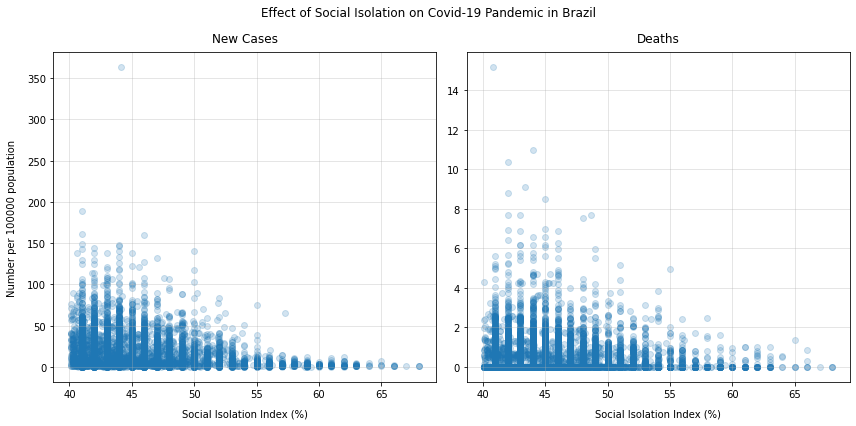

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

new_cases_pc = df['confirmed_day'].div(df['population'])
deaths = df['deaths_day'].div(df['population'])
withdrawal = df['withdrawal']

ax1.scatter(withdrawal*100, new_cases_pc*100000, alpha=0.2)
ax1.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax1.set_ylabel('Number per 100000 population', labelpad=10)
ax1.set_title('New Cases', pad=10)
ax1.grid(alpha=0.4)

ax2.scatter(withdrawal*100, deaths*100000, alpha=0.2)
ax2.set_xlabel('Social Isolation Index (%)', labelpad=10)
ax2.set_title('Deaths', pad=10)
ax2.grid(alpha=0.4)

fig.suptitle('Effect of Social Isolation on Covid-19 Pandemic in Brazil')
plt.tight_layout()
plt.show()

In this study, we use the social isolation index as a proxy for how the population is respecting social distance, and as a result of governmental policies. We can see that for social isolation ratings higher than 40%, both the number of new daily cases and the number of deaths are inversely correlated with isolation. This shows that social distance is indeed positive for containing the spread of the virus.

However, if we look at the death and new cases rates at the lower end of the isolation index, we notice a positive correlation. This may be due to the fact that when the number of cases is low, people start to go out and the government loosens restrictions, leading to an increase in the number of cases.

#### Social Isolation Effect over time in different cities

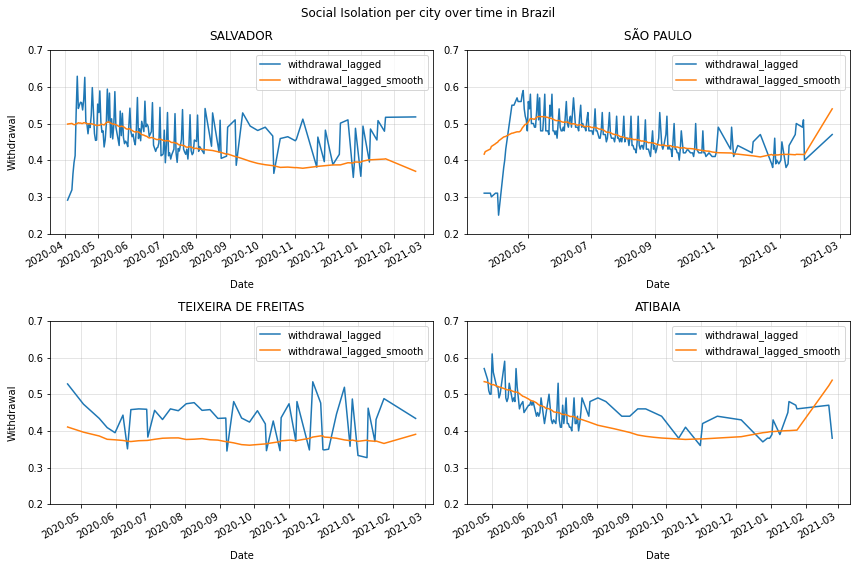

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8))

df[df['city_name']=='SALVADOR'].plot('date', 'withdrawal_lagged', ax=ax1)
df[df['city_name']=='SALVADOR'].plot('date', 'withdrawal_lagged_smooth', ax=ax1)
ax1.set_xlabel('Date', labelpad=10)
ax1.set_ylabel('Withdrawal', labelpad=10)
ax1.set_title('SALVADOR', pad=10)
ax1.set(ylim=(0.2, 0.7))
ax1.grid(alpha=0.4)

df[df['city_name']=='SÃO PAULO'].plot('date', 'withdrawal_lagged', ax=ax2)
df[df['city_name']=='SÃO PAULO'].plot('date', 'withdrawal_lagged_smooth', ax=ax2)
ax2.set_xlabel('Date', labelpad=10)
ax2.set_title('SÃO PAULO', pad=10)
ax2.set(ylim=(0.2, 0.7))
ax2.grid(alpha=0.4)

df[df['city_name']=='TEIXEIRA DE FREITAS'].plot('date', 'withdrawal_lagged', ax=ax3)
df[df['city_name']=='TEIXEIRA DE FREITAS'].plot('date', 'withdrawal_lagged_smooth', ax=ax3)
ax3.set_xlabel('Date', labelpad=10)
ax3.set_ylabel('Withdrawal', labelpad=10)
ax3.set_title('TEIXEIRA DE FREITAS', pad=10)
ax3.set(ylim=(0.2, 0.7))
ax3.grid(alpha=0.4)

df[df['city_name']=='ATIBAIA'].plot('date', 'withdrawal_lagged', ax=ax4)
df[df['city_name']=='ATIBAIA'].plot('date', 'withdrawal_lagged_smooth', ax=ax4)
ax4.set_xlabel('Date', labelpad=10)
ax4.set_title('ATIBAIA', pad=10)
ax4.set(ylim=(0.2, 0.7))
ax4.grid(alpha=0.4)

fig.suptitle('Social Isolation per city over time in Brazil')
plt.tight_layout()
plt.show()

We can see that the data from withdrawal has a noise because the behaveour of the population can be different during the week. To correct this, we applied a <mark>gaussian moving average</mark> to correct this and delayed the from 20 days based in some literature. Doing this we can see the real influence since the contamination (which has a direct influence with the withdrawal) and the death. All the parameter from the gaussian are based in this studies.

In the first row we can see the Capitals from SP and BA states: more populated cities and with strong economic power and policies, and the second row the opposite. 

In this graph we can see that the smaller cities have lower withdrawal rate in average.

### Regressions

#### Removing Serial Autocorrelation from Withdrawal

We can verify that the social withdrawal index is serially autocorrelated. Let's visualize this autocorrelation for the city of Salvador.

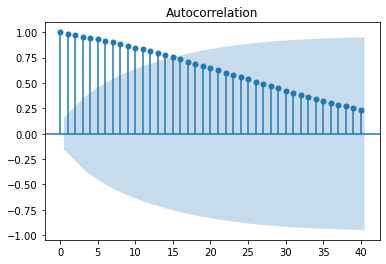

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df[df['city_name'] == 'SALVADOR']['withdrawal_lagged_smooth'], lags=40)
plt.show()

We can correct this issue by using the first difference of the social withdrawal. Let's apply this to our data and visualize autocorrelation.

In [19]:
df['withdrawal_diff'] = df.groupby(['city_code'])['withdrawal_lagged_smooth'].diff().values

In [20]:
# drop NaN values from dataset
# df.dropna(inplace=True)

In [ ]:
plot_acf(df[df['city_name'] == 'SALVADOR']['withdrawal_diff'], lags=40)
plt.show()

We can see that this technique significantly reduced autocorrelation. 

#### Panel OLS - Deaths per capita x Social Withdrawal

Let's start by comparing how the social isolation index affects on the number of deaths per capita by Covid-19. Initially, we're going to apply a Panel OLS with municipality time constant effects and time varying effects. In this case, the municipality time-constant effects would account for how each municipality dealed with the pandemics (specific measures by the city council and cultural particularities of each city). The time effects account for evolutions in the treatment of Covid-19, such as early detection of the desease and improved medical care.

In [23]:
y = df.loc[:,['city_code', 'date']]
y['deaths_day_pc'] = df['deaths_day_smooth'].div(df['population'])
y.set_index(['city_code', 'date'], inplace=True)

In [24]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff']])
X.set_index(['city_code', 'date'], inplace=True)

In [25]:
model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

/home/josebarretto/anaconda3/envs/study/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):             -0.0413
No. Observations:               12062   R-squared (Within):              -0.0025
Date:                Thu, Jun 17 2021   R-squared (Overall):             -0.0019
Time:                        00:44:11   Log-likelihood                 1.385e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.9617
Entities:                          97   P-value                           0.0028
Avg Obs:                       124.35   Distribution:                 F(1,11648)
Min Obs:                       34.000                                           
Max Obs:                       266.00   F-statistic (robust):             1.5013
                            

Here, we can see that the withdrawal has an inversely correlated effect with the number of deaths, which is not statistically significant.

Now, instead of using municipality time-constant effects in our model, we will use state effects. The reasoning for this change is that, in Brazil, Covid containment measures are defined by State governments, and therefore all municipalities are subject to state regulations.

In [26]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff', 'is_SP']])
X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=False, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0071
Estimator:                   PanelOLS   R-squared (Between):              0.0128
No. Observations:               12062   R-squared (Within):              -0.0024
Date:                Thu, Jun 17 2021   R-squared (Overall):              0.0067
Time:                        00:44:11   Log-likelihood                 1.362e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      41.949
Entities:                          97   P-value                           0.0000
Avg Obs:                       124.35   Distribution:                 F(2,11743)
Min Obs:                       34.000                                           
Max Obs:                       266.00   F-statistic (robust):             38.602
                            

In this case, we can see that the withdrawal variable did not change much, but there is a clear difference between the two states in terms of new cases per capita. As we can see, cities in the state of São Paulo have a statistically significant larger number of cases per capita.

#### Panel OLS - Deaths per capita x (Telecommunications + Social Withdrawal)

Now, let's continue the analysis by including telecommunications infrastructure variables into the model.

In [27]:
X = sm.tools.tools.add_constant(df[['city_code', 'date', 'withdrawal_diff']])

X['fixed_bandwidth'] = df['fixed_bandwidth_accesses'].div(df['population'])
X['cable_tv'] = df['cable_tv_accesses'].div(df['population'])
X['4G_mobile'] = df['4G_mobile_accesses'].div(df['population'])
X['3G_mobile'] = df['3G_mobile_accesses'].div(df['population'])
X['2G_mobile'] = df['2G_mobile_accesses'].div(df['population'])
X['fixed_telephony'] = df['fixed_telephony_accesses'].div(df['population'])

X.set_index(['city_code', 'date'], inplace=True)

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
res = model.fit(cov_type='clustered')
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          deaths_day_pc   R-squared:                        0.0040
Estimator:                   PanelOLS   R-squared (Between):              0.0034
No. Observations:               12062   R-squared (Within):              -0.0106
Date:                Thu, Jun 17 2021   R-squared (Overall):              0.0002
Time:                        00:44:12   Log-likelihood                 1.385e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.7625
Entities:                          97   P-value                           0.0000
Avg Obs:                       124.35   Distribution:                 F(7,11642)
Min Obs:                       34.000                                           
Max Obs:                       266.00   F-statistic (robust):             4.6141
                            

For this regression, when using state-level entity effects, we get positive correlations for all the telecommunications variables. This can be due to state-level effects not being able to account for differences between municipalities. 

When using city-level effects, however, we find that only two telecommunications variables are significant on the 5% confidence level - cable television and fixed telephony. The effect of Cable TV is statistically significant and negatively correlated to the number of deaths, which can indicate that having access to cable television contributes to the spread of information and the containment of the virus. On the other hand, a high number of fixed telephony accesses per capita indicates a higher number of Covid-19 deaths per capita. This is probably due to the fact that cities without modern telecom infrastructure tend to use this service more, and since fixed telephony is not a really an effective mechanism for spreading information nowadays, this can damage containment measures.

#### Two-Stage Panel OLS Model

In [28]:
from linearmodels import BetweenOLS
from linearmodels import RandomEffects
from linearmodels import BetweenOLS

# define types of columns
index_cols = [
    'city_code',
    'date'
]
control_cols = [
    #'gdp_pc',
    'density',
    #'urbanization',
    'blue_collar',
    #'white_collar',
    'is_SP'
]
telecom_cols = [
    'fixed_bandwidth_accesses',
    'cable_tv_accesses',
    '4G_mobile_accesses',
    '3G_mobile_accesses',
    '2G_mobile_accesses',
    'fixed_telephony_accesses'
]

### stage 1
# define X
X1 = sm.tools.tools.add_constant(df[index_cols + telecom_cols + control_cols])
X1[telecom_cols] = X1[telecom_cols].div(df['population'], axis=0)
X1['y_lag1'] = df.groupby('city_code')['withdrawal_lagged_smooth'].shift(1)
mask1 = ~X1['y_lag1'].isna()
X1 = X1[mask1]

# define y
y1 = df.loc[mask1,['city_code', 'date', 'withdrawal_lagged_smooth']]

# apply multi-index to dfs
X1.set_index(['city_code', 'date'], inplace=True)
y1.set_index(['city_code', 'date'], inplace=True)

# run model
stage1 = RandomEffects(y1, X1)
res1 = stage1.fit(cov_type='clustered')
print('First Stage Model:')
print(res1)

### stage 2
# define X
X2 = df.loc[:, ['city_code', 'date', 'deaths_day_smooth']]
X2['y_lag1'] = df.groupby('city_code')['deaths_day_smooth'].shift(1)
X2 = sm.tools.tools.add_constant(X2)
X2 = pd.merge(X2, res1.predict().reset_index(), on=['city_code', 'date'], how='right')

# define y
y2 = X2[['city_code', 'date', 'deaths_day_smooth']]
X2.drop(columns=['deaths_day_smooth'], inplace=True)

# apply multi-index to dfs
X2.set_index(['city_code', 'date'], inplace=True)
y2.set_index(['city_code', 'date'], inplace=True)

# run model
stage2 = PanelOLS(y2, X2, entity_effects=True, time_effects=True)
res2 = stage2.fit(cov_type='clustered')

print('\n\n\nSecond Stage Model:')
print(res2)

First Stage Model:
                           RandomEffects Estimation Summary                           
Dep. Variable:     withdrawal_lagged_smooth   R-squared:                        0.9527
Estimator:                    RandomEffects   R-squared (Between):              0.9980
No. Observations:                     12062   R-squared (Within):               0.9386
Date:                      Thu, Jun 17 2021   R-squared (Overall):              0.9527
Time:                              00:44:12   Log-likelihood                 3.778e+04
Cov. Estimator:                   Clustered                                           
                                              F-statistic:                   2.426e+04
Entities:                                97   P-value                           0.0000
Avg Obs:                             124.35   Distribution:                F(10,12051)
Min Obs:                             34.000                                           
Max Obs:                

#### Lockdown Measures

We collect some data about when happened strict measures in some cities in Brazil. For the ones that have some strict measure, we mark **1** and for when it was normal days **0**. For the cities we do not have much information, we put a **NaN**.

In [29]:
# Push the lockdown cities dataset
lockdown = pd.read_csv('./../data/raw_data/lockdown.csv')
lockdown['city_name'] = lockdown['city_name'].str.upper()
lockdown['begin_lockdown'] = pd.to_datetime(lockdown['begin_lockdown'])
lockdown['end_lockdown'] = pd.to_datetime(lockdown['end_lockdown'])

lockdown_cities = set(lockdown['city_name'].values)
cidades_total = set(df['city_name'].unique())
intersect_lockdown_cities = list(lockdown_cities.intersection(cidades_total))

df['strict_lockdown'] = df['cable_tv_accesses']*0

# for every city with lockdown, set 1 if it was a strict measure and a NaN 
# if don't have information about or did not do at all

for i in range(len(df)):
    
    if (len(lockdown[(lockdown['city_name']==df['city_name'].iloc[i]) & 
             (lockdown['begin_lockdown']<=df['date'].iloc[i]) &
             (lockdown['end_lockdown']>=df['date'].iloc[i])]) >0  ):
        df.iloc[i, df.columns.get_loc('strict_lockdown')] = 1

mask = df['city_name'].isin(intersect_lockdown_cities)
df['strict_lockdown'].where(mask, other=np.nan, inplace=True)

#### Corrections to Two-Stage Panel OLS

##### Verifying correlations

In [30]:
# define types of columns
index_cols = [
    'city_code',
    'date'
]
control_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
    'is_SP'
]
telecom_cols = [
    'fixed_bandwidth_accesses',
    'cable_tv_accesses',
    '4G_mobile_accesses',
    '3G_mobile_accesses',
    '2G_mobile_accesses',
    'fixed_telephony_accesses'
]

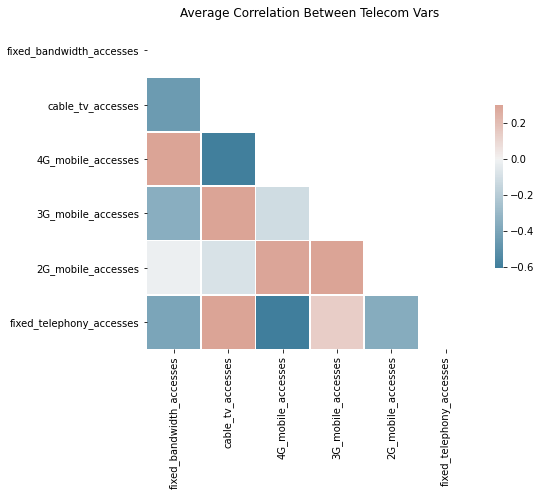

In [31]:
telecom_corr = df[index_cols + telecom_cols].groupby(['city_code']).corr().mean(level=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(telecom_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(telecom_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Average Correlation Between Telecom Vars')
plt.show()

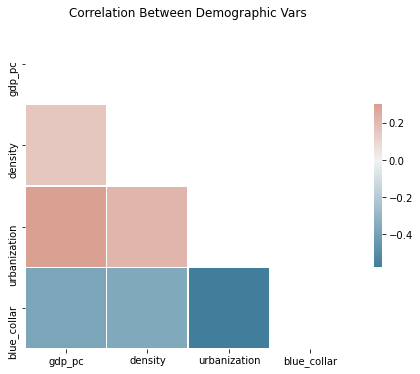

In [32]:
demographic_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
]

demographic_corr = df_cities_static[demographic_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(demographic_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(demographic_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Between Demographic Vars')
plt.show()

##### Corrected two-stage OLS model

In [33]:
from linearmodels import BetweenOLS
from linearmodels import RandomEffects
from linearmodels import BetweenOLS

# define types of columns
index_cols = [
    'city_code',
    'date'
]
control_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
    'is_SP',
]
telecom_cols = [
    'fixed_bandwidth_accesses',
    'cable_tv_accesses',
    '4G_mobile_accesses',
    '3G_mobile_accesses',
    '2G_mobile_accesses',
    'fixed_telephony_accesses'
]

### stage 1
# define X
X1 = sm.tools.tools.add_constant(df[index_cols + telecom_cols + control_cols])
X1[telecom_cols] = X1[telecom_cols].div(df['population'], axis=0)
X1['strict_lockdown'] = df['strict_lockdown'] == 1
X1['no_lockdown'] = df['strict_lockdown'] == 0

X1['monday'] = pd.DatetimeIndex(df['date']).weekday == 0
X1['tuesday'] = pd.DatetimeIndex(df['date']).weekday == 1
X1['wednesday'] = pd.DatetimeIndex(df['date']).weekday == 2
X1['thursday'] = pd.DatetimeIndex(df['date']).weekday == 3
X1['friday'] = pd.DatetimeIndex(df['date']).weekday == 4
X1['saturday'] = pd.DatetimeIndex(df['date']).weekday == 5

X1['y_lag1'] = df.groupby('city_code')['withdrawal_lagged_smooth'].shift(1)
mask1 = ~X1['y_lag1'].isna()
X1 = X1[mask1]

# define y
y1 = df.loc[mask1,['city_code', 'date', 'withdrawal_lagged_smooth']]

# apply multi-index to dfs
X1.set_index(['city_code', 'date'], inplace=True)
y1.set_index(['city_code', 'date'], inplace=True)

# run model
stage1 = RandomEffects(y1, X1)
res1 = stage1.fit(cov_type='clustered')
print('First Stage Model:')
print(res1)

### stage 2
# define X
X2 = df.loc[:, ['city_code', 'date', 'deaths_day_smooth'] + control_cols]
X2['y_lag1'] = df.groupby('city_code')['deaths_day_smooth'].shift(1)
X2 = sm.tools.tools.add_constant(X2)
# X2['monday'] = pd.DatetimeIndex(df['date']).weekday == 0
# X2['tuesday'] = pd.DatetimeIndex(df['date']).weekday == 1
# X2['wednesday'] = pd.DatetimeIndex(df['date']).weekday == 2
# X2['thursday'] = pd.DatetimeIndex(df['date']).weekday == 3
# X2['friday'] = pd.DatetimeIndex(df['date']).weekday == 4
# X2['saturday'] = pd.DatetimeIndex(df['date']).weekday == 5

X2 = pd.merge(X2, res1.predict().reset_index(), on=['city_code', 'date'], how='right')

# define y
y2 = X2[['city_code', 'date', 'deaths_day_smooth']]
X2.drop(columns=['deaths_day_smooth'], inplace=True)

# apply multi-index to dfs
X2.set_index(['city_code', 'date'], inplace=True)
y2.set_index(['city_code', 'date'], inplace=True)

# run model
stage2 = PanelOLS(y2, X2, entity_effects=False, time_effects=True)
res2 = stage2.fit(cov_type='clustered')

print('\n\n\nSecond Stage Model:')
print(res2)

First Stage Model:
                           RandomEffects Estimation Summary                           
Dep. Variable:     withdrawal_lagged_smooth   R-squared:                        0.9528
Estimator:                    RandomEffects   R-squared (Between):              0.9980
No. Observations:                     12062   R-squared (Within):               0.9387
Date:                      Thu, Jun 17 2021   R-squared (Overall):              0.9528
Time:                              00:44:27   Log-likelihood                  3.78e+04
Cov. Estimator:                   Clustered                                           
                                              F-statistic:                   1.215e+04
Entities:                                97   P-value                           0.0000
Avg Obs:                             124.35   Distribution:                F(20,12041)
Min Obs:                             34.000                                           
Max Obs:                